## Accès à la base de données sur l'éclairage depuis une API et importation du DataFrame

In [1]:
import requests
import pandas as pd
import geopandas as gpd

api_root_eclairage = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/"
ID_eclairage = "eclairage-public"
url_api_eclairage = api_root_eclairage + ID_eclairage + "/exports/json"
print(url_api_eclairage)

try:
    response = requests.get(url_api_eclairage)
    response.raise_for_status()
    wb = response.json()
except requests.exceptions.RequestException as e:
    print(f"Erreur lors de la requête : {e}")
except ValueError:
    print("Erreur : Impossible de décoder le JSON.")


df_eclairage = pd.DataFrame(wb)
df_eclairage.head()

/home/yasmine/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/yasmine/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/eclairage-public/exports/json


,cod_ouvrag,foyer,lib_domain,lib_ouvrag,observatio,posx_ouvra,posy_ouvra,lib_regime,voievent_v,faceop_ouv,...,volt_lampe,prod_ouv_2,tempcouleu,lib_lampef,lib_four_3,gradation,ulor,dlor,geo_shape,geo_point_2d
0,44904,1505142,Eclairage Public,Candélabre,None,648916.384212,6.861016e+06,HORAIRE EP,GARIBALDI (BOULEVARD),None,...,230.0,None,2000.0,Lampe sodium haute pression substituée,PHILIPS,NaN,2.0,68.0,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 2.303905940798113, 'lat': 48.847162358..."
1,45122,1406697,Eclairage Public,Console,None,651134.377731,6.858661e+06,HORAIRE EP,GAUGUET (RUE),None,...,230.0,None,2000.0,Lampe sodium haute pression substituée,PHILIPS,NaN,3.0,74.0,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 2.3343986547361024, 'lat': 48.82615129..."
2,45128,1709763,Eclairage Public,Console,None,650168.294246,6.865957e+06,HORAIRE EP,GAUTHEY (RUE),None,...,230.0,None,2000.0,Lampe sodium haute pression substituée,PHILIPS,NaN,3.0,76.0,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 2.3203849048916827, 'lat': 48.89168911..."
3,45067,045067-481,Eclairage Public,Projecteur,None,647477.994276,6.861243e+06,24/24 (OU CIRC/NUIT/1/1BIS),GASTON DE CAILLAVET (RUE),None,...,220.0,None,3000.0,Tube fluorescent,None,NaN,NaN,NaN,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 2.284278708748253, 'lat': 48.849084116..."
4,45067,045067-573,Eclairage Public,Projecteur,None,647477.994276,6.861243e+06,24/24 (OU CIRC/NUIT/1/1BIS),GASTON DE CAILLAVET (RUE),None,...,220.0,None,3000.0,Tube fluorescent,None,NaN,NaN,NaN,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 2.284278708748253, 'lat': 48.849084116..."


In [2]:
df_eclairage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171226 entries, 0 to 171225
Data columns (total 69 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   cod_ouvrag    171226 non-null  object 
 1   foyer         171226 non-null  object 
 2   lib_domain    171226 non-null  object 
 3   lib_ouvrag    171226 non-null  object 
 4   observatio    35126 non-null   object 
 5   posx_ouvra    171226 non-null  float64
 6   posy_ouvra    171226 non-null  float64
 7   lib_regime    171223 non-null  object 
 8   voievent_v    171226 non-null  object 
 9   faceop_ouv    0 non-null       object 
 10  numvoie_ou    100037 non-null  object 
 11  bister_ouv    0 non-null       object 
 12  nature_voi    171226 non-null  object 
 13  lib_voie      171226 non-null  object 
 14  lib_voiedo    171226 non-null  object 
 15  lib_secteu    171226 non-null  object 
 16  lib_region    171226 non-null  object 
 17  lib_regi_1    171226 non-null  object 
 18  cod_

## Sélection des variables pertinentes à la problématique

In [3]:
df_eclairage_flt = df_eclairage[['cod_ouvrag', 'foyer', 'lib_domain', 'lib_ouvrag', 'posx_ouvra', 'posy_ouvra', 'lib_regime', 'voievent_v', 'numvoie_ou', 'nature_voi', 'lib_voie', 'lib_voiedo', 'lib_secteu', 'lib_region', 'lib_regi_1', 'geo_shape']]
df_eclairage_flt.head()

In [4]:
df_eclairage_flt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171226 entries, 0 to 171225
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   cod_ouvrag    171226 non-null  object 
 1   foyer         171226 non-null  object 
 2   lib_domain    171226 non-null  object 
 3   lib_ouvrag    171226 non-null  object 
 4   posx_ouvra    171226 non-null  float64
 5   posy_ouvra    171226 non-null  float64
 6   lib_regime    171223 non-null  object 
 7   voievent_v    171226 non-null  object 
 8   numvoie_ou    100037 non-null  object 
 9   nature_voi    171226 non-null  object 
 10  lib_voie      171226 non-null  object 
 11  lib_voiedo    171226 non-null  object 
 12  lib_secteu    171226 non-null  object 
 13  lib_region    171226 non-null  object 
 14  lib_regi_1    171226 non-null  object 
 15  geo_shape     171226 non-null  object 
 16  geo_point_2d  171226 non-null  object 
dtypes: float64(2), object(15)
memory usage: 22.2+ MB

## Statistiques descriptives 

In [5]:
print(f"Nombre total de points lumineux : {df_eclairage_flt.shape[0]}")
coverage_by_arrondissement = df_eclairage_flt['lib_region'].value_counts()
print(coverage_by_arrondissement)

Nombre total de points lumineux : 171226
lib_region
PERIPHERIQUE         31802
Arrondissement 15    13210
Arrondissement 12    12545
Arrondissement 16    12390
Arrondissement 19    11642
Arrondissement 13    11429
Arrondissement 17     9414
Arrondissement 08     8525
Arrondissement 18     8366
Arrondissement 14     7968
Arrondissement 20     7820
Arrondissement 01     6517
Arrondissement 07     5205
Arrondissement 11     4424
Arrondissement 04     3616
Arrondissement 10     3521
Arrondissement 05     3417
Arrondissement 09     2604
Arrondissement 03     2392
Arrondissement 06     2343
Arrondissement 02     2076
Name: count, dtype: int64


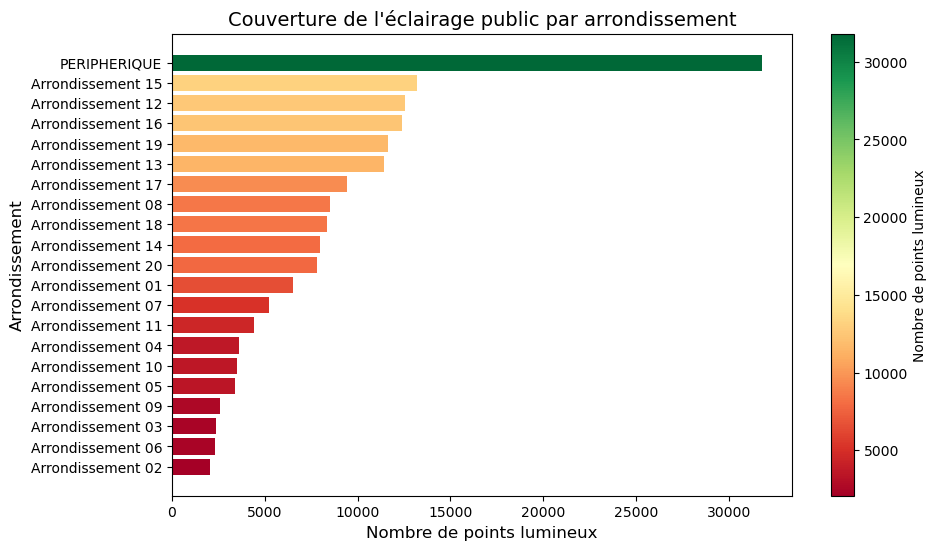

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


coverage_sorted = coverage_by_arrondissement.sort_values()
norm = mcolors.Normalize(vmin=coverage_sorted.min(), vmax=coverage_sorted.max())
cmap = plt.cm.RdYlGn
colors = [cmap(norm(value)) for value in coverage_sorted]


plt.figure(figsize=(10, 6))
plt.barh(coverage_sorted.index, coverage_sorted.values, color=colors)
plt.xlabel("Nombre de points lumineux", fontsize=12)
plt.ylabel("Arrondissement", fontsize=12)
plt.title("Couverture de l'éclairage public par arrondissement", fontsize=14)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Nombre de points lumineux")
plt.show()


## Importation d'une base contenant les arrondissements de Paris depuis une API

In [28]:
url_api_arrondissements = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/records?limit=20"
response2 = requests.get(url_api_arrondissements)
data = response2.json() 
results = data.get("results", []) 
df_arrondissements = pd.DataFrame(results)
df_arrondissements.head()
df_arrondissements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   n_sq_ar    20 non-null     int64  
 1   c_ar       20 non-null     int64  
 2   c_arinsee  20 non-null     int64  
 3   l_ar       20 non-null     object 
 4   l_aroff    20 non-null     object 
 5   n_sq_co    20 non-null     int64  
 6   surface    20 non-null     float64
 7   perimetre  20 non-null     float64
 8   geom_x_y   20 non-null     object 
 9   geom       20 non-null     object 
dtypes: float64(2), int64(4), object(4)
memory usage: 1.7+ KB


In [8]:
df_arrondissements_flt = df_arrondissements[['c_ar', 'l_ar', 'surface', 'geom']]
df_arrondissements_flt.loc[:, 'surface'] = df_arrondissements_flt['surface'] / 1e6
df_arrondissements_flt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   c_ar     20 non-null     int64  
 1   l_ar     20 non-null     object 
 2   surface  20 non-null     float64
 3   geom     20 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 768.0+ bytes


## Réalisation d'une jointure avec la base d'éclairage

In [9]:
df_eclairage_flt['num_region'] = df_eclairage_flt['lib_region'].str.extract(r'(\d+)') 
df_eclairage_flt['num_region'] = df_eclairage_flt.apply(
    lambda row: "PERIPHERIQUE" if row['lib_region'] == "PERIPHERIQUE" else int(row['num_region']), axis=1
)
df_eclairage_flt[['lib_region', 'num_region']].head()
df_eclairage_flt.info()



/tmp/ipykernel_4665/584100600.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eclairage_flt['num_region'] = df_eclairage_flt['lib_region'].str.extract(r'(\d+)')
/tmp/ipykernel_4665/584100600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eclairage_flt['num_region'] = df_eclairage_flt.apply(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171226 entries, 0 to 171225
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   cod_ouvrag    171226 non-null  object 
 1   foyer         171226 non-null  object 
 2   lib_domain    171226 non-null  object 
 3   lib_ouvrag    171226 non-null  object 
 4   posx_ouvra    171226 non-null  float64
 5   posy_ouvra    171226 non-null  float64
 6   lib_regime    171223 non-null  object 
 7   voievent_v    171226 non-null  object 
 8   numvoie_ou    100037 non-null  object 
 9   nature_voi    171226 non-null  object 
 10  lib_voie      171226 non-null  object 
 11  lib_voiedo    171226 non-null  object 
 12  lib_secteu    171226 non-null  object 
 13  lib_region    171226 non-null  object 
 14  lib_regi_1    171226 non-null  object 
 15  geo_shape     171226 non-null  object 
 16  geo_point_2d  171226 non-null  object 
 17  num_region    171226 non-null  object 
dtypes: f

In [10]:
df_combined = pd.merge(
    df_eclairage_flt, 
    df_arrondissements_flt, 
    left_on='num_region',  
    right_on='c_ar',      
    how='inner'            
)
df_combined.info()
df_combined = df_combined.rename(columns={
    'surface': 'surface_arr',
    'geom': 'geom_arr'
})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139424 entries, 0 to 139423
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   cod_ouvrag    139424 non-null  object 
 1   foyer         139424 non-null  object 
 2   lib_domain    139424 non-null  object 
 3   lib_ouvrag    139424 non-null  object 
 4   posx_ouvra    139424 non-null  float64
 5   posy_ouvra    139424 non-null  float64
 6   lib_regime    139421 non-null  object 
 7   voievent_v    139424 non-null  object 
 8   numvoie_ou    92991 non-null   object 
 9   nature_voi    139424 non-null  object 
 10  lib_voie      139424 non-null  object 
 11  lib_voiedo    139424 non-null  object 
 12  lib_secteu    139424 non-null  object 
 13  lib_region    139424 non-null  object 
 14  lib_regi_1    139424 non-null  object 
 15  geo_shape     139424 non-null  object 
 16  geo_point_2d  139424 non-null  object 
 17  num_region    139424 non-null  object 
 18  c_ar

## Représentation de la densité des points lumineux par arrondissement

In [12]:
coverage_by_arrondissement2 = df_combined['c_ar'].value_counts()
coverage_df = coverage_by_arrondissement2.reset_index()
coverage_df.columns = ['c_ar', 'Nombre_points_lumineux']

df_densite = pd.merge(
    df_arrondissements_flt,
    coverage_df,
    on='c_ar',
    how='left'  
)



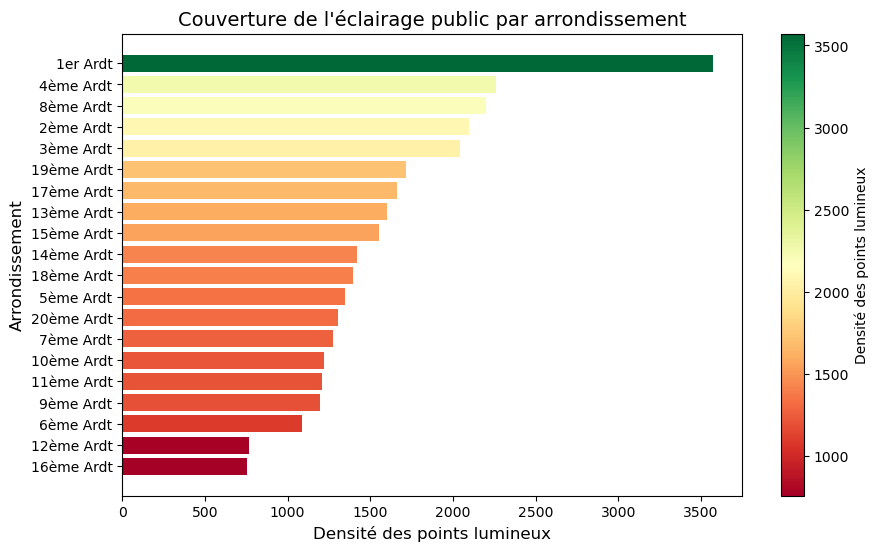

In [13]:
df_densite['densité_lum'] = df_densite['Nombre_points_lumineux'] / df_densite['surface']

coverage_sorted = df_densite.sort_values(by='densité_lum', ascending=True)
norm = mcolors.Normalize(vmin=coverage_sorted['densité_lum'].min(), vmax=coverage_sorted['densité_lum'].max())
cmap = plt.cm.RdYlGn  
colors = [cmap(norm(value)) for value in coverage_sorted['densité_lum']]

plt.figure(figsize=(10, 6))
plt.barh(coverage_sorted['l_ar'], coverage_sorted['densité_lum'], color=colors)
plt.xlabel("Densité des points lumineux", fontsize=12)
plt.ylabel("Arrondissement", fontsize=12)
plt.title("Couverture de l'éclairage public par arrondissement", fontsize=14)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="Densité des points lumineux")

plt.show()


## Représentation sur une carte

In [16]:
import geopandas as gpd
from shapely.geometry import Point


df_eclairage_flt['geometry'] = df_eclairage['geo_shape'].apply(lambda x: Point(x['geometry']['coordinates']))
gdf_eclairage = gpd.GeoDataFrame(df_eclairage_flt, geometry='geometry', crs="EPSG:4326")  

/tmp/ipykernel_4665/2589452429.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eclairage_flt['geometry'] = df_eclairage['geo_shape'].apply(lambda x: Point(x['geometry']['coordinates']))


In [18]:
!pip install folium
pip install ipython
#pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.1/110.1 KB 2.4 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 KB 6.4 MB/s eta 0:00:00


In [35]:
import folium
from IPython.display import display
m = folium.Map(location=[48.8566, 2.3522], zoom_start=12)


for _, row in gdf_eclairage.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],  
        radius=0.5,  
        color='yellow',
        fill=True,
        fill_color='yellow'
    ).add_to(m)

#m.save("points_lumineux.html")


In [36]:
from folium import Choropleth
from shapely.geometry import shape

df_densite['geometry'] = df_densite['geom'].apply(lambda x: shape(x['geometry']))
gdf_densite = gpd.GeoDataFrame(df_densite, geometry='geometry', crs="EPSG:4326")
Choropleth(
    geo_data=gdf_densite,
    data=gdf_densite,
    columns=["l_ar", "densité_lum"],  
    key_on="feature.properties.l_ar",  
    fill_color="RdYlGn",  
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Densité des points lumineux"
).add_to(m)

for _, row in gdf_densite.iterrows():
    folium.Popup(f"Arrondissement: {row['c_ar']}<br>Densité: {row['densité_lum']:.2f}").add_to(
        folium.GeoJson(row['geometry'])
    )

#m.save("carte_densite.html")

